In [10]:
import tweepy
from tweepy import OAuthHandler

from nltk.tokenize import word_tokenize
# from gsdmm import MovieGroupProcess
# from topic_allocation import top_words, topic_attribution
# from visualisation import plot_topic_notebook, save_topic_html
from sklearn.datasets import fetch_20newsgroups
from chart_studio.tools import set_config_file
set_config_file(plotly_domain="https://plotly.com", plotly_api_domain="https://api.plotly.com")

import pickle
import matplotlib as plt
import ast

from textblob import TextBlob
import nltk
import seaborn as sns
import re, string
import sys
import time
from google.oauth2.service_account import Credentials
import logging

import datetime 


import time, sys
from IPython.display import clear_output
from tqdm import tqdm
import platform,socket, os
from google.oauth2.service_account import Credentials
import logging


import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
from nltk import PorterStemmer
import gensim
from gensim.utils import simple_preprocess
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import PorterStemmer
from nltk.stem.porter import *
import os
# Run in python console
import nltk; nltk.download('stopwords')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pandas as pd
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Scraping twitter 

### Scraping My Twitter Feed with the Tweepy API 

Tweepy is twitter library for Python that uses twitter API (special interface purposed for automated use and developed by Twitter). 

In [5]:
# Consumer keys and access tokens, used for OAuth

CONSUMER_KEY ='xxxxxxx'
CONSUMER_SECRET ='xxxxxxx'
access_token ='xxxxxxx'
access_secret ='xxxxxxx'

# OAuth process, using the keys and tokens
auth = OAuthHandler(consumer_key=CONSUMER_KEY, consumer_secret=CONSUMER_SECRET)
auth.set_access_token(access_token, access_secret)
 
# Creation of the actual interface, using authentication  
api = tweepy.API(auth)

# Sample method, used to update a status

for status in tweepy.Cursor(api.home_timeline).items(10):
    # Process a single status
    print(status.text)

What divides US? Whatever divides us cannot as long as we are conscious. Stay conscious, you’ll never be brainwashe… https://t.co/uBRc7xMDvc
The cities of Hiroshima and Nagasaki are recruiting “legacy successors” who will inherit the stories of atom-bomb s… https://t.co/619YKfRj6A
The cities of Hiroshima and Nagasaki are recruiting “legacy successors” who will inherit the stories of atom-bomb s… https://t.co/7Xtm1U4UQ4
RT @TIME: TIME’s new cover: How COVID-19 changed everything about the 2020 election https://t.co/WcGbCk7j7t https://t.co/Bwq5PyKBzR
RT @toshpolela: Herman Mashaba could be the main beneficiary of South Africa’s shifting political landscape  https://t.co/MHG3U8ZKuC
WATCH: Biden gets in testy exchange with reporter who asked if he's taken a cognitive exam: "Why the hell would I t… https://t.co/zfbOqkc6cQ
We saw and Alakhe does not quite understand why he would have been going anywhere but ke celebrate we will https://t.co/pyRQ5zy2On
RT @MorobadiK: This is so heartbreaking.

# Tweepy vs TwitterScraper 

An issue with using tweepy and twitter's api is, there is a rate limit of number of twitter calls from a particular user per hour. if we want large amount of data like a 10 million tweets this will take forever. Searching through tweets between a particular period was not effective while using twitter's api. Luckily, with TwitterScraper there is no such limitation.

Here I am scraping Tweets which had the following terms from the trending searches on the topic over the days since

In [ ]:
from twitterscraper import query_tweets
import warnings

# https://twitter.com/search-advanced
list_of_tweets = query_tweets('PrayForLebanon OR Beruit OR Lebanon OR explosion OR Beirut_Explosion OR PrayForBeirut or Lebanese Red Cross OR Liban', 
         begindate=datetime.date(2020, 8, 4), 
         enddate=datetime.date(2020, 8, 6), 
         lang='en')
# Convert list of tweets to DataFrame
tweets_df = pd.DataFrame([vars(x) for x in list_of_tweets])

# twitter scraper tends to print out large warnings so ignore these
warnings.filterwarnings('ignore')

In [57]:
tweets_df.shape

(13526, 1)

 # Text Pre-processing
* Convert all words to lowercase
* Remove non-alphabet characters and generaly cleaning with regex


In [17]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
import nltk

In [18]:

documents = tweets_df.copy()
documents = documents[['text']]

# Convert all words to lowercase
documents['text'] = documents['text'].str.lower()

# Remove non-alphabet
documents['text'].str.replace('[^a-zA-Z]', '') 
documents['text'] = documents['text'].str.replace('\d+', '')
documents['text'] = documents['text'].str.replace('\n', '')
documents.head(10)

,text
0,what is so wrong about wanting to live?💔 #pale...
1,so lemme get this straight;a moldovan🇲🇩 flagge...
2,"""on aug , an enormous explosion destroyed the ..."
3,"i mean, yeah, fires happen everyday. bas in le..."
4,lebanon. deserves. better.im sobbing reading t...
5,which generals told you the lebanon explosion ...
6,i vote @jeffbezos donates billion dollars to ...
7,dylan can you talk about what's happening in l...
8,tell lebanon’s cedars that palestine’s olives ...
9,has the us govt offered humanitarian aid to le...


## Prepare Stopwords

‘Stop words’ are commonly used words that are unlikely to have any benefit in natural language processing. These includes words such as ‘a’, ‘the’, ‘is’.

In [20]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','twitter','https','com','status'])

In [34]:
from pprint import pprint

# Convert to list
data = documents.text.tolist()
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Remove short words (length < 3)
data = [re.sub(r'\b\w{1,2}\b', '', sent) for sent in data]

pprint(data[:1])

['what   wrong about wanting  live?💔 #palestine🇵🇸 #yemen🇾🇪 #lebanon']


## Tokenize words and Clean-up text

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [35]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['what', 'wrong', 'about', 'wanting', 'live', 'palestine', 'yemen', 'lebanon']]


In [36]:
print(data_words[:1])

[['what', 'wrong', 'about', 'wanting', 'live', 'palestine', 'yemen', 'lebanon']]


## Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.



In [37]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[340]]])

['hiiii', 'wanna', 'help', 'lebanon', 'but', 'can', 'donate', 'any', 'money', 'broke', 'what', 'else', 'can']


In [38]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[340]]])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

['hiiii', 'wanna', 'help', 'lebanon', 'but', 'can', 'donate', 'any', 'money', 'broke', 'what', 'else', 'can']


In [39]:
#Let’s call the functions in order.

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['wrong', 'want', 'live']]


## Create the Dictionary and Corpus needed for Topic Modeling

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [40]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('live', 1), ('want', 1), ('wrong', 1)],
 [('aim', 1),
  ('base', 1),
  ('end', 1),
  ('flagged', 1),
  ('get', 1),
  ('impound', 1),
  ('leave', 1),
  ('own', 1),
  ('port', 1),
  ('ship', 1)],
 [('can', 1),
  ('city', 1),
  ('destroy', 1),
  ('devastation', 1),
  ('donate', 1),
  ('enormous', 1),
  ('help', 1),
  ('injure', 1),
  ('kill', 1),
  ('least', 1),
  ('life', 1),
  ('likely', 1),
  ('number', 1),
  ('people', 4),
  ('recover', 1),
  ('rise', 1),
  ('save', 1),
  ('understate', 1)],
 [('ajman', 1),
  ('bomb', 2),
  ('clearly', 1),
  ('fire', 2),
  ('go', 1),
  ('happen', 1),
  ('make', 1),
  ('mean', 1),
  ('normal', 1),
  ('plant', 1),
  ('really', 1),
  ('sense', 1),
  ('something', 1)],
 [('read', 1), ('sob', 1)]]

In [42]:
flat_list = [item for sublist in data_lemmatized for item in sublist]

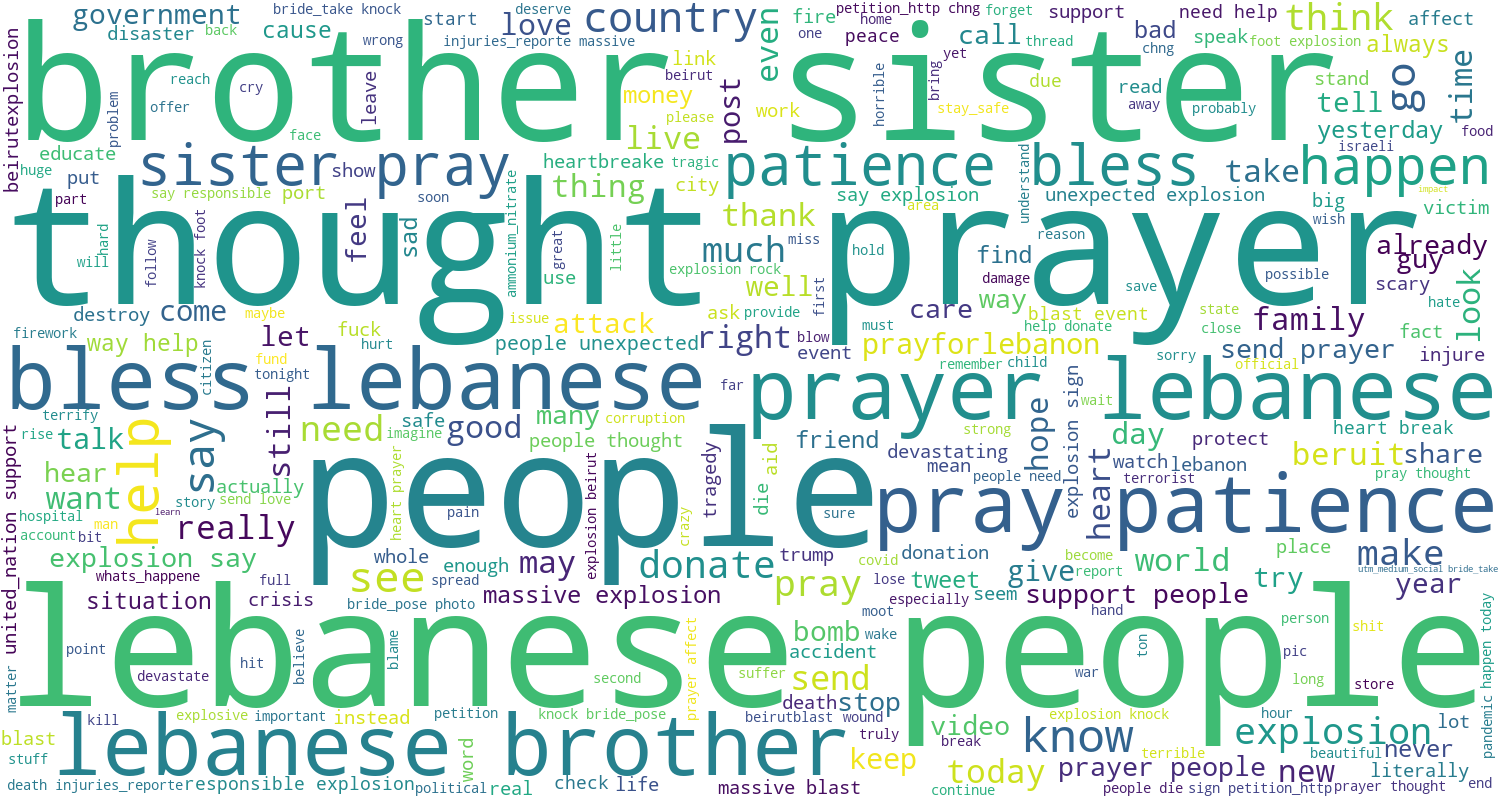

In [44]:
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(flat_list)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=300, contour_width=3, contour_color='steelblue',width=1500, height=800)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Building the Topic Model

In [58]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.032*"happen" + 0.019*"say" + 0.018*"see" + 0.017*"explosion" + '
  '0.016*"today" + 0.012*"look" + 0.011*"time" + 0.011*"way" + 0.010*"take" + '
  '0.009*"get"'),
 (1,
  '0.036*"explosion" + 0.019*"know" + 0.018*"blast" + 0.017*"send" + '
  '0.016*"need" + 0.015*"go" + 0.014*"much" + 0.013*"massive" + 0.013*"injure" '
  '+ 0.012*"support"'),
 (2,
  '0.093*"people" + 0.092*"lebanese" + 0.088*"pray" + 0.081*"prayer" + '
  '0.049*"thought" + 0.041*"brother" + 0.040*"sister" + 0.040*"bless" + '
  '0.039*"help" + 0.038*"patience"')]


## Compute Model Perplexity and Coherence Score

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [59]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.357255691594382

Coherence Score:  0.30396239135197645


# Topic Visualization

Use pyLDAvis, an interactive LDA visualization package, to plot all generated topics and their keywords. pyLDAvis calculates semantic distance between topics and projects topics on a 2D plane.

Here  bubble size of the represents "importance" of the topic and distance between the bubbles reflects the similarity between topics. The closer the two circles are, the more similar the topics are.
I have experimented with various permutations on number of topics to get to the three main topics below which emerge. A good topic model should have some dominant bigger bubbles, with smaller ones scattered on the plane and avoid overlaps which shows topic infusions. 

At th

In [60]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.165991  0.257109       1        1  35.476212
1     -0.177178 -0.251581       2        1  33.015087
2      0.343169 -0.005528       3        1  31.508696, topic_info=            Term         Freq        Total Category  logprob  loglift
26        people  2696.000000  2696.000000  Default  30.0000  30.0000
185     lebanese  2656.000000  2656.000000  Default  29.0000  29.0000
51          pray  2541.000000  2541.000000  Default  28.0000  28.0000
187       prayer  2347.000000  2347.000000  Default  27.0000  27.0000
189      thought  1403.000000  1403.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
228  devastating   122.303337   123.262100   Topic3  -5.4661   1.1471
249         good   162.964264   164.274048   Topic3  -5.1790   1.1469
161        scary   106.858086   107.739937   Topic3  -5.6011   1.1467
13           can   134.044830   135.153259   Topic3  -5.3744   1.1467
355      tragedy   146.492050   149.476151   Topic3  -5.2856   1.1347

[130 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
454       3  0.998095  affect
482       1  0.998357  beruit
443       1  0.997117     big
152       2  0.998575   blast
183       3  0.999079   bless
...     ...       ...     ...
60        1  0.996790     way
635       1  0.997905    well
112       2  0.998514   world
253       1  0.997757   would
78        1  0.997769    year

[119 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

# Interpreting the topics

So all this is cool but what can we make of the pyLDAvis visuals ? Its a difficulty task to interpret the meaning of the different topics because what you get out of the model is just a large probability mass function over all the possible words for each topic i.e. the red tells us the frequency of words given a topic. 
Most of the confusion arises by using word freqency per topic to try distinguish between topics. As an example explosion occurs as a top word for both topic 1 and 2 

### Lambda to the rescue. 

Using λ, you can re-rank words and introduce words that are more relavant to the topic of interest by decreasing the value of λ (frequency of topic / overall word frequncy). This makes the topics more readable. The word explosion completely disapears from topic one 


* Topic one now clearly indicates the social media exposure and enquiry into the Beruit explosion with words such as Happen, see, video among the top. 
* Topic Three speaks to the outflow of compassion from users urging people to pray for the Lebanese people with top words such as Lebanese. sisters, brothers, pray and donate being frequent. 
* Topic three speaks directly to the blast itself and the casualties which arose with top words such as blast, explosion, injure and 